# Air Quality Forecasting

*Predicting pollution using advanced time series analysis*

**Author:** Virginia Herrero

## Introduction

This project covers the full machine learning process for predicting air quality using time series data. The notebook walks through every step, from cleaning the data to building and evaluating models.

This project was originally built for a technical screening, however, later was adapted into a portfolio project. The dataset was chosen because it relates to a background in chemical engineering with a focus on quality control. Predicting air quality is a practical way to apply skills in engineering and data science, especially within quality control across various industries.

## Dataset

The dataset used in this project was obtained from the UCI Machine Learning Repository [here](https://archive.ics.uci.edu/dataset/360/air+quality).

Key info about the dataset:

- It contains 9,358 hourly averaged readings from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. This device was placed at road level in a heavily polluted area within an Italian city.

- Data was collected from March 2004 to February 2005—making it the longest freely available dataset of on-field air quality chemical sensor responses.

- Ground truth hourly averaged concentrations for CO, Non-Methanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx), and Nitrogen Dioxide (NO<sub>2</sub>) were provided by a certified reference analyzer located nearby.

- Missing values are marked with a -200 value.

The dataset includes the following variables:

- `Date`: (DD/MM/YYYY)

- `Time`: (HH.MM.SS)

- `CO(GT)`: True hourly averaged concentration CO in mg/m^3 (reference analyzer)

- `PT08.S1(CO)`: (tin oxide) hourly averaged sensor response (nominally CO targeted)

- `NMHC(GT)`: True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)

- `C6H6(GT)`: True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)

- `PT08.S2(NMHC)`: (titania) hourly averaged sensor response (nominally NMHC targeted)

- `NOx(GT)`: True hourly averaged NOx concentration in ppb (reference analyzer)

- `PT08.S3(NOx)`: (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)

- `NO2(GT)`: True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)

- `PT08.S4(NO2)`: (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)

- `PT08.S5(O3)`: (indium oxide) hourly averaged sensor response (nominally O3 targeted)

- `T`: Temperature in °C

- `RH`: Relative Humidity (%)

- `AH`: Absolute Humidity

## Data Loading

Load the CSV file **AirQualityUCI** as a pandas DataFrame.

In [1]:
# Project setup
%run ../notebooks/setup_path.py
from config import *

# Import all required libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Seasonal analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Modeling and evaluation
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load the dataset
df = pd.read_csv(RAW_DIR / "AirQualityUCI.csv", delimiter = ";", decimal = ",")
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


## Data Cleaning

The first step of the project involved cleaning and preprocessing the dataset to ensure the quality and consistency of the data. This included handling missing values, correcting data types, and removing any obvious errors or outliers. Proper cleaning is essential to prepare the data for accurate analysis and reliable model training.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


- **Remove unnecessary columns**

The columns `Unnamed: 15` and `Unnamed: 16`  contained no data and were removed from the dataset to keep it clean and focused.

In [4]:
df = df.drop(["Unnamed: 15", "Unnamed: 16"], axis = 1)

- **Rename columns**

Some columns were renamed to make their meaning clearer and easier to understand, especially for readers without a technical background.

In [5]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

In [6]:
df = df.rename(columns = {"CO(GT)" : "CO_Concentration",
                          "PT08.S1(CO)" : "CO_Sensor_Response",
                          "NMHC(GT)" : "NMHC_Concentration",
                          "C6H6(GT)" : "C6H6_Concentration",
                          "PT08.S2(NMHC)" : "NMHC_Sensor_Response",
                          "NOx(GT)" : "NOx_Concentration",
                          "PT08.S3(NOx)" : "NOx_Sensor_Response",
                          "NO2(GT)" : "NO2_Concentration",
                          "PT08.S4(NO2)" : "NO2_Sensor_Response",
                          "PT08.S5(O3)" : "O3_Sensor_Response",
                          "T" : "Temperature",
                          "RH" : "Relative_Humidity",
                          "AH" : "Absolute_Humidity"})

In [7]:
# Show the dataset with the renamed variables
df.head()

,Date,Time,CO_Concentration,CO_Sensor_Response,NMHC_Concentration,C6H6_Concentration,NMHC_Sensor_Response,NOx_Concentration,NOx_Sensor_Response,NO2_Concentration,NO2_Sensor_Response,O3_Sensor_Response,Temperature,Relative_Humidity,Absolute_Humidity
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


- **Null values**

Identify and remove any null values in the dataset to ensure data quality before analysis.

In [8]:
# Check the total of null values in each column
df.isna().sum()

Date                    114
Time                    114
CO_Concentration        114
CO_Sensor_Response      114
NMHC_Concentration      114
C6H6_Concentration      114
NMHC_Sensor_Response    114
NOx_Concentration       114
NOx_Sensor_Response     114
NO2_Concentration       114
NO2_Sensor_Response     114
O3_Sensor_Response      114
Temperature             114
Relative_Humidity       114
Absolute_Humidity       114
dtype: int64

In [9]:
# Show all the rows with missing values
missing_rows = df[df.isna().any(axis = 1)]
missing_rows

,Date,Time,CO_Concentration,CO_Sensor_Response,NMHC_Concentration,C6H6_Concentration,NMHC_Sensor_Response,NOx_Concentration,NOx_Sensor_Response,NO2_Concentration,NO2_Sensor_Response,O3_Sensor_Response,Temperature,Relative_Humidity,Absolute_Humidity
9357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset contains 114 missing values, which is about 1.2 percent of the total data. Since this is a small proportion, removing rows with missing values is a reasonable approach to maintain data quality.

In [10]:
# Drop missing values
df = df.dropna()

The dataset description indicates that missing values are labeled with -200. Therefore, all occurrences of -200 will be identified and replaced with NaN values.


In [11]:
# Count -200 values in each column
df.apply(lambda x : x == -200).sum()

Date                       0
Time                       0
CO_Concentration        1683
CO_Sensor_Response       366
NMHC_Concentration      8443
C6H6_Concentration       366
NMHC_Sensor_Response     366
NOx_Concentration       1639
NOx_Sensor_Response      366
NO2_Concentration       1642
NO2_Sensor_Response      366
O3_Sensor_Response       366
Temperature              366
Relative_Humidity        366
Absolute_Humidity        366
dtype: int64

The count analysis of -200 values clearly shows that the feature **"NMHC\_Concentration"** has a significant number of missing values. Because of this, the column will be dropped. For the remaining missing values in the dataset, forward fill imputation will be used. This method works well for time series data since it maintains the temporal order without creating artificial duplicates. These steps ensure the dataset is clean and ready for the next stages of analysis.

In [12]:
# Drop the colum with too many missing values
df.drop(columns = ["NMHC_Concentration"], inplace = True)

In [13]:
# Replace values with NaN
df.replace(to_replace = -200, value = np.nan, inplace = True)

In [14]:
# Forward fill missing values
df.ffill(inplace = True)

In [15]:
# Check remaining missing values
df.isna().sum()

Date                    0
Time                    0
CO_Concentration        0
CO_Sensor_Response      0
C6H6_Concentration      0
NMHC_Sensor_Response    0
NOx_Concentration       0
NOx_Sensor_Response     0
NO2_Concentration       0
NO2_Sensor_Response     0
O3_Sensor_Response      0
Temperature             0
Relative_Humidity       0
Absolute_Humidity       0
dtype: int64

- **Duplicate Values**

Check the dataset for any duplicate entries and remove them if found to ensure data integrity and avoid biased analysis.

In [16]:
df.duplicated().sum()

0

The dataset contains no duplicate values.


- **Data Types**

Verify that each column has the correct data type to ensure proper processing and accurate analysis throughout the project.

In [17]:
df.dtypes

Date                     object
Time                     object
CO_Concentration        float64
CO_Sensor_Response      float64
C6H6_Concentration      float64
NMHC_Sensor_Response    float64
NOx_Concentration       float64
NOx_Sensor_Response     float64
NO2_Concentration       float64
NO2_Sensor_Response     float64
O3_Sensor_Response      float64
Temperature             float64
Relative_Humidity       float64
Absolute_Humidity       float64
dtype: object

The **"Date"** and **"Time"** columns are currently stored as object types. To work with time series data effectively, these columns should be converted to datetime types. This conversion enables accurate time-based operations and analysis.

In [18]:
# Create new feature with date and time
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format = "%d/%m/%Y %H.%M.%S")

# Set the new feature as the index
df = df.set_index("Datetime")

# Drop the unnecesary columns
df = df.drop(["Date", "Time"], axis = 1)
df

,CO_Concentration,CO_Sensor_Response,C6H6_Concentration,NMHC_Sensor_Response,NOx_Concentration,NOx_Sensor_Response,NO2_Concentration,NO2_Sensor_Response,O3_Sensor_Response,Temperature,Relative_Humidity,Absolute_Humidity
Datetime,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406


In [19]:
# Check again for missing values after transformation
df.isna().sum()

CO_Concentration        0
CO_Sensor_Response      0
C6H6_Concentration      0
NMHC_Sensor_Response    0
NOx_Concentration       0
NOx_Sensor_Response     0
NO2_Concentration       0
NO2_Sensor_Response     0
O3_Sensor_Response      0
Temperature             0
Relative_Humidity       0
Absolute_Humidity       0
dtype: int64

- **Outliers**

Review the dataset’s statistical summary to spot potential outliers. This overview helps identify any unusual values that might require closer examination before moving forward.

In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CO_Concentration,9357.0,2.082195,1.469801,0.1000,1.0000,1.7000,2.8000,11.900
CO_Sensor_Response,9357.0,1102.730362,219.588101,647.0000,938.0000,1062.0000,1237.0000,2040.000
C6H6_Concentration,9357.0,10.190392,7.565771,0.1000,4.4000,8.3000,14.0000,63.700
NMHC_Sensor_Response,9357.0,942.548253,269.581368,383.0000,733.0000,911.0000,1117.0000,2214.000
NOx_Concentration,9357.0,240.731217,206.618453,2.0000,97.0000,174.0000,318.0000,1479.000
NOx_Sensor_Response,9357.0,832.742225,255.709423,322.0000,655.0000,807.0000,968.0000,2683.000
NO2_Concentration,9357.0,109.414877,47.221662,2.0000,73.0000,102.0000,137.0000,340.000
NO2_Sensor_Response,9357.0,1453.014535,347.434084,551.0000,1228.0000,1460.0000,1677.0000,2775.000
O3_Sensor_Response,9357.0,1030.511916,410.916759,221.0000,726.0000,964.0000,1287.0000,2523.000
Temperature,9357.0,18.317356,8.821883,-1.9000,11.9000,17.6000,24.3000,44.600


From the dataset’s summary statistics, it’s clear that the following variables show significant discrepancies between their maximum values and the upper quartile, indicating potential outliers:

- CO_Concentration
- C<sub>6</sub>H<sub>6</sub>_Concentration
- NO<sub>x</sub>_Concentration

First, these variables will be visualized to spot possible outliers. Then, outliers will be identified using the Interquartile Range (IQR) method. Analyzing the data distribution will reveal values outside the typical range, helping us decide the best way to handle them.

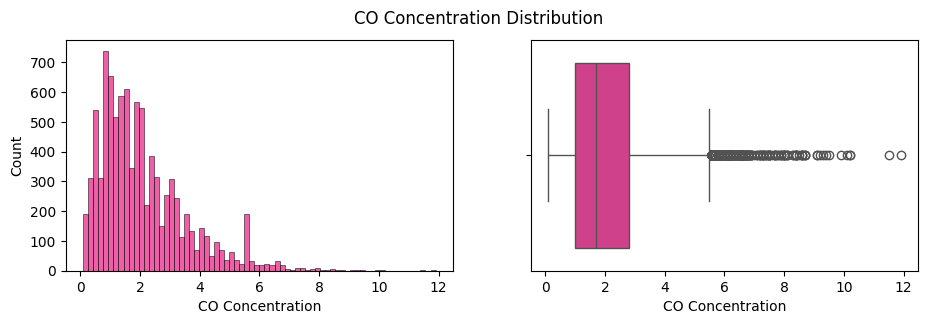

In [21]:
# Plot the CO concentration distribution using a histogram and boxplot
fig, ax = plt.subplots(1, 2, figsize = (11, 3))
sns.histplot(df["CO_Concentration"], ax = ax[0], color = "#e7298a")
sns.boxplot(x = df["CO_Concentration"], ax = ax[1], color = "#e7298a")
ax[0].set_xlabel("CO Concentration")
ax[1].set_xlabel("CO Concentration")
plt.suptitle("CO Concentration Distribution", size = 12);

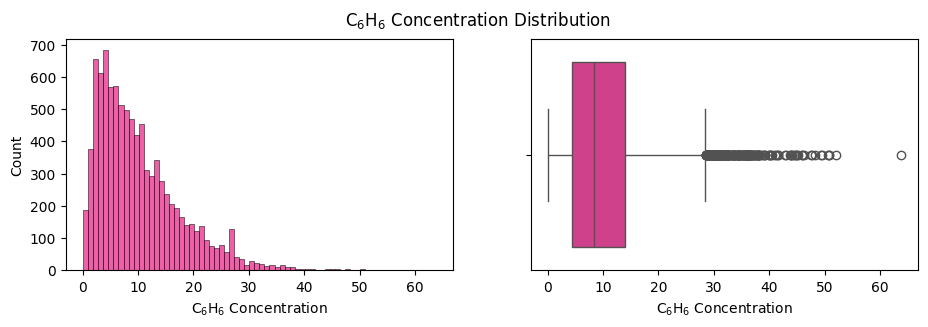

In [22]:
# Plot the C6H6 concentration distribution using a histogram and boxplot
fig, ax = plt.subplots(1, 2, figsize = (11, 3))
sns.histplot(df["C6H6_Concentration"], ax = ax[0], color = "#e7298a")
sns.boxplot(x = df["C6H6_Concentration"], ax = ax[1], color = "#e7298a")
ax[0].set_xlabel("C$_6$H$_6$ Concentration")
ax[1].set_xlabel("C$_6$H$_6$ Concentration")
plt.suptitle("C$_6$H$_6$ Concentration Distribution", size = 12);

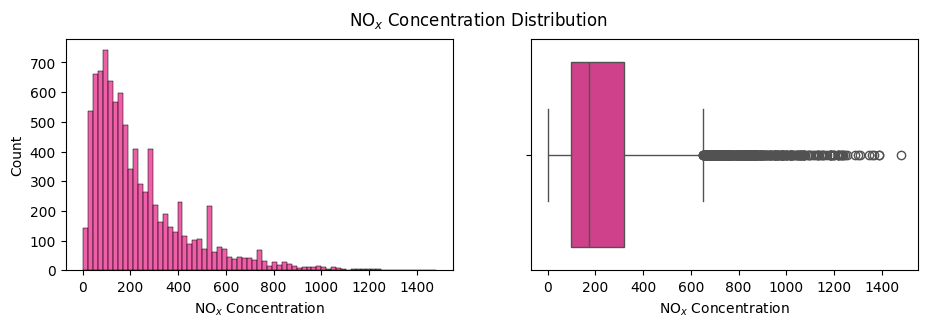

In [23]:
# Plot the NOx concentration distribution using a histogram and boxplot
fig, ax = plt.subplots(1, 2, figsize = (11, 3))
sns.histplot(df["NOx_Concentration"], ax = ax[0], color = "#e7298a")
sns.boxplot(x = df["NOx_Concentration"], ax = ax[1], color = "#e7298a")
ax[0].set_xlabel("NO$_x$ Concentration")
ax[1].set_xlabel("NO$_x$ Concentration")
plt.suptitle("NO$_x$ Concentration Distribution", size = 12);

Outliers will be identified using the Interquartile Range (IQR) method. This approach detects values that fall below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR. Using this method helps isolate data points that deviate significantly from the typical range, allowing for informed decisions on how to address them.

In [24]:
# Create a function to find outliers using the IQR method

def find_outliers_iqr(dataframe, column):
    """
    Finds outliers in the specified column of a DataFrame using the IQR method

    Parameters
    ----------
    dataframe : Pandas DataFrame
        The DataFrame containing the data
    
    column : str
        The name of the column (as a string) in which to find the outliers

    Returns
    -------
    Pandas DataFrame
        A DataFrame containing the outliers identified in the specified column
   """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Determine the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    print(f"The number of outliers in the column {column} is {outliers.shape[0]}")
    
    return outliers

In [25]:
# Find outliers in the dataset
for i in df.columns:
    find_outliers_iqr(df, i)

The number of outliers in the column CO_Concentration is 403
The number of outliers in the column CO_Sensor_Response is 105
The number of outliers in the column C6H6_Concentration is 236
The number of outliers in the column NMHC_Sensor_Response is 61
The number of outliers in the column NOx_Concentration is 510
The number of outliers in the column NOx_Sensor_Response is 240
The number of outliers in the column NO2_Concentration is 123
The number of outliers in the column NO2_Sensor_Response is 95
The number of outliers in the column O3_Sensor_Response is 72
The number of outliers in the column Temperature is 4
The number of outliers in the column Relative_Humidity is 0
The number of outliers in the column Absolute_Humidity is 2


Based on the outlier analysis, there are several values that fall well outside the typical range. Given the nature of the data, these points could reflect actual pollution spikes, which may be important signals rather than errors. Still, extreme values can negatively affect model performance. To balance these concerns, outliers will be capped. This approach keeps all data while reducing the impact of extreme cases on the model.

In [26]:
def cap_outliers(dataframe, column):
    """
    Cap outliers in a specified column of the DataFrame using the IQR method

    Parameters
    ----------
    dataframe : Pandas DataFrame
        The DataFrame containing the data
    
    column : str
        The name of the column to cap outliers


    Returns
    -------
    Pandas DataFrame
        A DataFrame with outliers capped
    """
    if column not in dataframe.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")
    
    # Calculate Q1 and Q3
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)

    # Calculate IQR

    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers
    dataframe[column] = dataframe[column].clip(lower = lower_bound, upper = upper_bound)

    return dataframe

In [27]:
# Cap outliers
for i in df.columns:
    cap_outliers(df, i)

The plots below show the distribution of the selected features after capping the outliers. This step helps confirm that the data is now within a more reasonable range, making it better suited for modeling while still preserving important variation.

Text(0.5, 0.98, 'Feature Distributions')

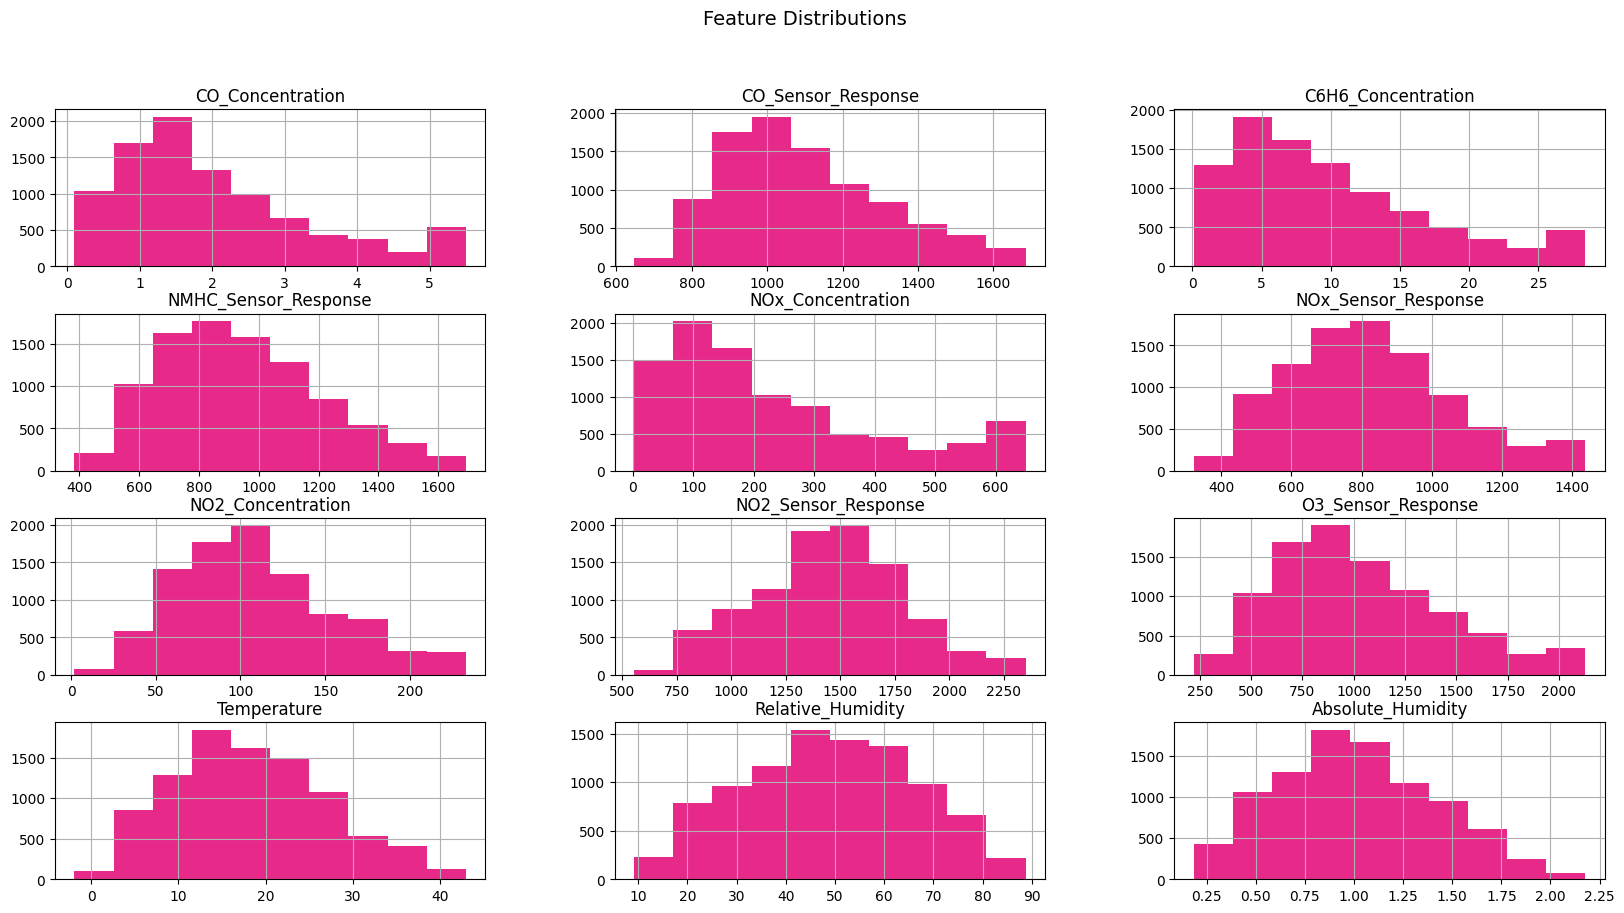

In [28]:
df.hist(figsize = (20, 10), color = "#e7298a")
plt.suptitle("Feature Distributions", fontsize = 14)

- **The clean dataset**

After completing the cleaning steps, the dataset is now free of missing values, duplicates, and extreme outliers. All columns are properly typed, and the structure is ready for analysis and modeling.

In [29]:
air_quality = df.copy()
air_quality.head()

,CO_Concentration,CO_Sensor_Response,C6H6_Concentration,NMHC_Sensor_Response,NOx_Concentration,NOx_Sensor_Response,NO2_Concentration,NO2_Sensor_Response,O3_Sensor_Response,Temperature,Relative_Humidity,Absolute_Humidity
Datetime,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [30]:
# Save the cleaned dataset
air_quality.to_csv(PROCESSED_DIR / "Air-quality-cleaned-dataset.csv")

## Checking for Seasonality in the Time Series

This project requires the time series to be non-seasonal, meaning it should not contain repeating patterns at regular intervals.

To verify this, the Augmented Dickey-Fuller (ADF) test is used. This test checks if the series is stationary, meaning its statistical properties like mean and variance are constant over time. While stationarity is a desirable property for many time series models, it does not necessarily imply the absence of seasonality.

In this case, the ADF test returned a very low p-value, well below the 0.05 threshold. The ADF statistic was also lower than all critical values. This confirms that the series is stationary.

Although the series is stationary according to the ADF test, this does not rule out the presence of seasonality. Further analysis is needed to detect repeating seasonal patterns.

In [31]:
def check_seasonality(series):
    """
    Perform the Dickey-Fuller test to check for stationarity.

    This helps assess whether the time series is suitable for modeling,
    though it does not directly detect seasonality.

    Parameters
    ----------
    series : Pandas Series
        The time series data to test for seasonality.
    
    Returns
    -------
    None
    """
    result = adfuller(series)
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    # Print the results
    print("Dickey-Fuller Test Results:\n")
    print(f"ADF Statistic: {adf_statistic}")
    print(f"p-value: {p_value}")

    for key, value in critical_values.items():
        print(f"Critical Value {key}: {value}")
    
    # Interpretation    
    interpretation = ("The time series is stationary. However, this does not confirm the absence of seasonality."
                  if p_value < 0.05 else
                  "The time series is non-stationary, which may indicate the presence of a trend or seasonality.")
    print(f"\nInterpretation: {interpretation}")

In [32]:
# Check seasonality on target variable
adf_result = check_seasonality(air_quality["NO2_Concentration"])

Dickey-Fuller Test Results:

ADF Statistic: -8.058854638763542
p-value: 1.663903547992562e-12
Critical Value 1%: -3.4310515338067336
Critical Value 5%: -2.8618500337363275
Critical Value 10%: -2.566935025875756

Interpretation: The time series is stationary. However, this does not confirm the absence of seasonality.


### **Seasonal Decomposition**

To check for repeating patterns in the NO<sub>2</sub> concentration series, a seasonal decomposition was applied. This process separates the time series into three parts: trend, seasonal, and residual. The trend shows long-term movement, the seasonal part highlights any repeating cycles, and the residual captures what remains after removing trend and seasonality.

Since the dataset is based on hourly readings, the two most likely seasonal patterns are daily (24-hour) and weekly (168-hour). The decomposition was done twice, once for each of these expected cycles.

The results show clear and consistent seasonal patterns in both daily and weekly decompositions. These seasonal effects have a strong presence compared to the observed values, which points to seasonality being a major factor in the time series. The trend component shows broader changes over time, while the residuals leave some unexplained variation, but not enough to account for the repeating cycles.

Although the Dickey-Fuller test showed that the series is stationary, the decomposition makes it clear that seasonality is present. This highlights an important distinction: the ADF test detects stochastic trends and unit roots but does not capture deterministic seasonal cycles. Seasonal decomposition is more appropriate for identifying structured seasonal effects.

In summary, while the ADF test initially suggested the series was stationary, further analysis through seasonal decomposition revealed strong daily and weekly seasonality. Deseasonalizing the series and reapplying the ADF test confirmed that the underlying series is stationary once seasonality is removed.

In [33]:
# Infer frequency
print(air_quality.index.inferred_freq)

# Alternatively, check time difference between first few rows
print(air_quality.index.to_series().diff().value_counts())

h
Datetime
0 days 01:00:00    9356
Name: count, dtype: int64


<Figure size 1100x500 with 0 Axes>

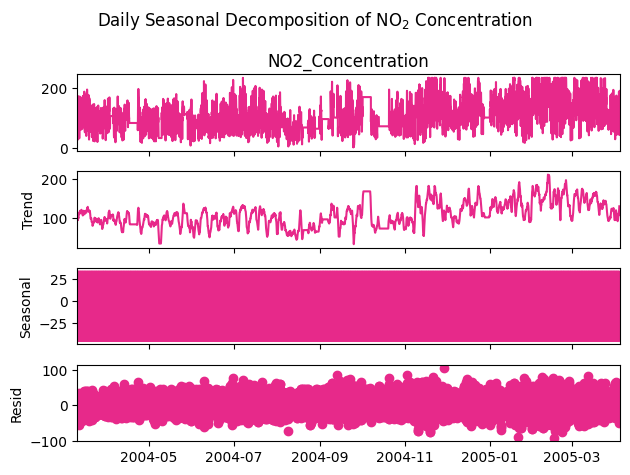

<Figure size 1100x500 with 0 Axes>

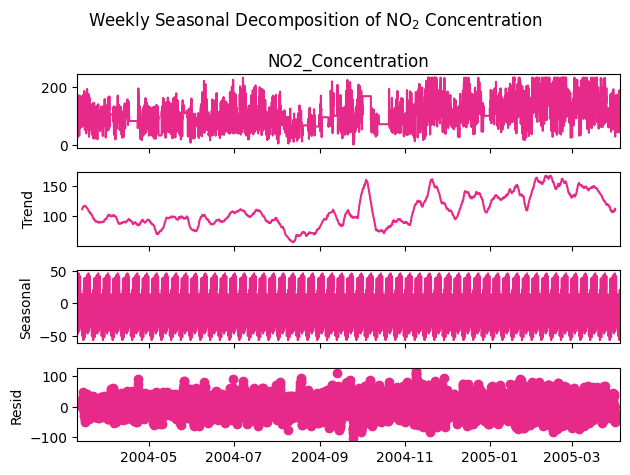

In [34]:
# Daily seasonality check
daily_result = seasonal_decompose(air_quality["NO2_Concentration"], model = "additive", period = 24)

plt.figure(figsize = (11, 5))
daily_result.plot()
plt.suptitle("Daily Seasonal Decomposition of NO$_2$ Concentration")
plt.tight_layout()

# Change the color of the lines
for ax in plt.gcf().axes:
    for line in ax.lines:
        line.set_color("#e7298a")

# Weekly seasonality check
weekly_result = seasonal_decompose(air_quality["NO2_Concentration"], model = "additive", period = 168)

plt.figure(figsize = (11, 5))
weekly_result.plot()
plt.suptitle("Weekly Seasonal Decomposition of NO$_2$ Concentration")
plt.tight_layout()

# Change the color of the lines
for ax in plt.gcf().axes:
    for line in ax.lines:
        line.set_color("#e7298a")

### **Removing Seasonality and Verifying Stationarity**

The previous analysis showed that the NO<sub>2</sub> concentration series has strong seasonal patterns. To meet the project requirement of using a non-seasonal time series, seasonality needs to be removed. This is done by subtracting the seasonal component from the original series, resulting in a deseasonalized version.

The decomposition was based on a daily cycle, using a period of 24 hours. After removing the seasonal effect, both the original and deseasonalized series were plotted to compare their patterns visually.

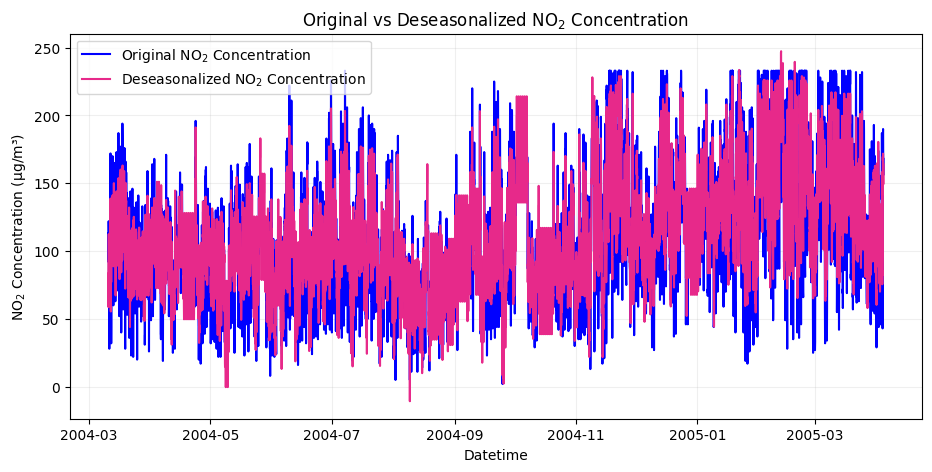

In [35]:
# Perform seasonal decomposition with daily period
decomposition = seasonal_decompose(air_quality["NO2_Concentration"], model = "additive", period = 24)

# Create deseasonalized series by subtracting seasonal component
air_quality["NO2_Deseasonalized"] = air_quality["NO2_Concentration"] - decomposition.seasonal

# Plot original and deseasonalized series
plt.figure(figsize = (11, 5))
plt.plot(air_quality["NO2_Concentration"], label = "Original NO$_2$ Concentration", color = "blue")
plt.plot(air_quality["NO2_Deseasonalized"], label = "Deseasonalized NO$_2$ Concentration", color = "#e7298a")
plt.legend()
plt.title("Original vs Deseasonalized NO$_2$ Concentration")
plt.xlabel("Datetime")
plt.ylabel("NO$_2$ Concentration (µg/m³)")
plt.grid (alpha = 0.2);

### **Confirming Stationarity After Deseasonalization**

The Dickey-Fuller test on the deseasonalized series returned the following results:

* **ADF Statistic**: -7.67
* **p-value**: approximately 1.62e-11
* **Critical values** (1%, 5%, 10%): all higher than the ADF statistic

These results confirm that the deseasonalized series is stationary. The very low p-value and the ADF statistic being below all critical thresholds provide strong evidence that the seasonal patterns have been effectively removed. This makes the data suitable for modeling without seasonal adjustments.

In [36]:
# Run Dickey-Fuller test on deseasonalized series (drop missing values)
result = adfuller(air_quality["NO2_Deseasonalized"].dropna())

# Print test statistics and critical values
print("Dickey-Fuller Test on Deseasonalized Series:\n")
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
for key, value in result[4].items():
    print(f"Critical Value {key}: {value}")

# Interpretation
if result[1] < 0.05:
    print("\nInterpretation: The deseasonalized series is stationary, suggesting the seasonality has been effectively removed.")
else:
    print("\nInterpretation: The deseasonalized series is still non-stationary, further preprocessing may be needed.")

Dickey-Fuller Test on Deseasonalized Series:

ADF Statistic: -7.668624965910616
p-value: 1.6158572433491114e-11
Critical Value 1%: -3.43105123289464
Critical Value 5%: -2.861849900767839
Critical Value 10%: -2.566934955096094

Interpretation: The deseasonalized series is stationary, suggesting the seasonality has been effectively removed.


## Exploratory Data Analysis

This section explores the key characteristics of the dataset through visualizations and summary statistics. The goal is to better understand the distribution of variables, detect potential relationships, and identify any trends or patterns that could influence modeling decisions.

### **Target Variable**

The target variable in this project is the concentration of NO₂. This choice is based on several key reasons:

- NO<sub>2</sub> is among the most harmful pollutants in the dataset.
- Its adverse health effects are well documented.
- Regulatory agencies have set clear and strict limits for NO<sub>2</sub> levels.

Since the original time series showed strong seasonality, the seasonal component was removed through decomposition. The resulting deseasonalized NO<sub>2</sub> series will be used going forward to ensure the model focuses on underlying trends and patterns without seasonal bias.

Below, it is explored the deseasonalized NO<sub>2</sub> concentration over time and its distribution to better understand its behavior.

In [37]:
# Deseasonalized series
deseasonalized_no2 = air_quality["NO2_Deseasonalized"].dropna()

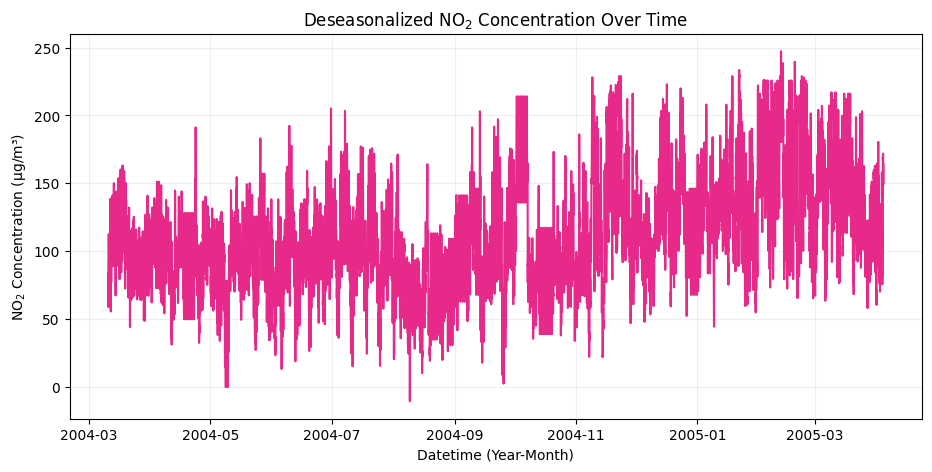

In [38]:
# Time Series Plot
plt.figure(figsize = (11, 5))
plt.plot(deseasonalized_no2, color = "#e7298a")
plt.title("Deseasonalized NO$_2$ Concentration Over Time")
plt.xlabel("Datetime (Year-Month)")
plt.ylabel("NO$_2$ Concentration (µg/m³)")
plt.grid(alpha = 0.2)

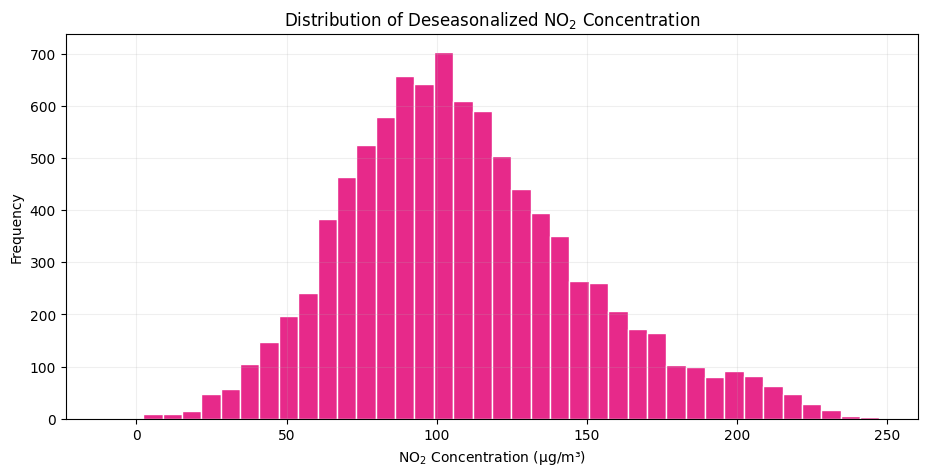

In [39]:
# Distribution Plot
plt.figure(figsize = (11, 5))
plt.hist(deseasonalized_no2, bins = 40, color = "#e7298a", edgecolor = "white")
plt.title("Distribution of Deseasonalized NO$_2$ Concentration")
plt.xlabel("NO$_2$ Concentration (µg/m³)")
plt.ylabel("Frequency")
plt.grid(alpha = 0.2)

### **Features**

Features are key variables used for predicting NO<sub>2</sub> concentration. Understanding these variables helps highlight which factors influence air quality and how they relate to the target variable.

In [40]:
features = air_quality.drop(["NO2_Concentration", "NO2_Sensor_Response", "NO2_Deseasonalized"], axis = 1)

In [41]:
# Drop unnecessary columns and resample the data by month, calculating the mean
monthly_mean = features.drop(["Temperature", "Relative_Humidity", "Absolute_Humidity"], axis = 1).resample("ME").mean()

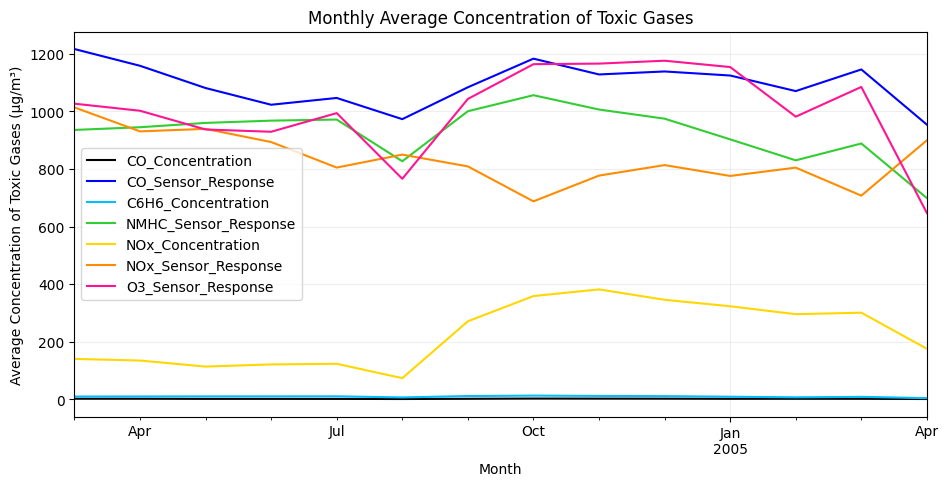

In [42]:
# Plot monthly average values of all the gases
colors = ["black", "blue", "deepskyblue", "limegreen", "gold", "darkorange", "deeppink"]

monthly_mean.plot(figsize = (11, 5), color = colors)
plt.xlabel("Month")
plt.ylabel("Average Concentration of Toxic Gases (µg/m³)")
plt.title("Monthly Average Concentration of Toxic Gases")
plt.legend(loc = "best")
plt.grid(alpha = 0.2)
plt.savefig(FIGURES_DIR / "monthly-concentration-toxic-gases.png")

- **Correlation Matrix**

Examining the correlation matrix helps identify the relationships between features and the target variable. This analysis highlights which variables have the strongest associations with NO<sub>2</sub> concentration and may contribute most to the model’s predictive power.

In [43]:
correlations = features.corr(numeric_only = True)
correlations

,CO_Concentration,CO_Sensor_Response,C6H6_Concentration,NMHC_Sensor_Response,NOx_Concentration,NOx_Sensor_Response,O3_Sensor_Response,Temperature,Relative_Humidity,Absolute_Humidity
CO_Concentration,1.000000,0.765333,0.778404,0.773354,0.782162,-0.660841,0.741894,0.009747,0.033885,0.024396
CO_Sensor_Response,0.765333,1.000000,0.892196,0.896396,0.645460,-0.811667,0.902649,0.038123,0.119894,0.122366
C6H6_Concentration,0.778404,0.892196,1.000000,0.988009,0.629585,-0.787485,0.870559,0.201692,-0.065680,0.157225
NMHC_Sensor_Response,0.773354,0.896396,0.988009,1.000000,0.626433,-0.827560,0.877289,0.233307,-0.084350,0.174966
NOx_Concentration,0.782162,0.645460,0.629585,0.626433,1.000000,-0.666965,0.713075,-0.246271,0.184930,-0.142399
NOx_Sensor_Response,-0.660841,-0.811667,-0.787485,-0.827560,-0.666965,1.000000,-0.827628,-0.124300,-0.069037,-0.214892
O3_Sensor_Response,0.741894,0.902649,0.870559,0.877289,0.713075,-0.827628,1.000000,-0.043904,0.138144,0.056959
Temperature,0.009747,0.038123,0.201692,0.233307,-0.246271,-0.124300,-0.043904,1.000000,-0.570756,0.654850
Relative_Humidity,0.033885,0.119894,-0.065680,-0.084350,0.184930,-0.069037,0.138144,-0.570756,1.000000,0.180504
Absolute_Humidity,0.024396,0.122366,0.157225,0.174966,-0.142399,-0.214892,0.056959,0.654850,0.180504,1.000000


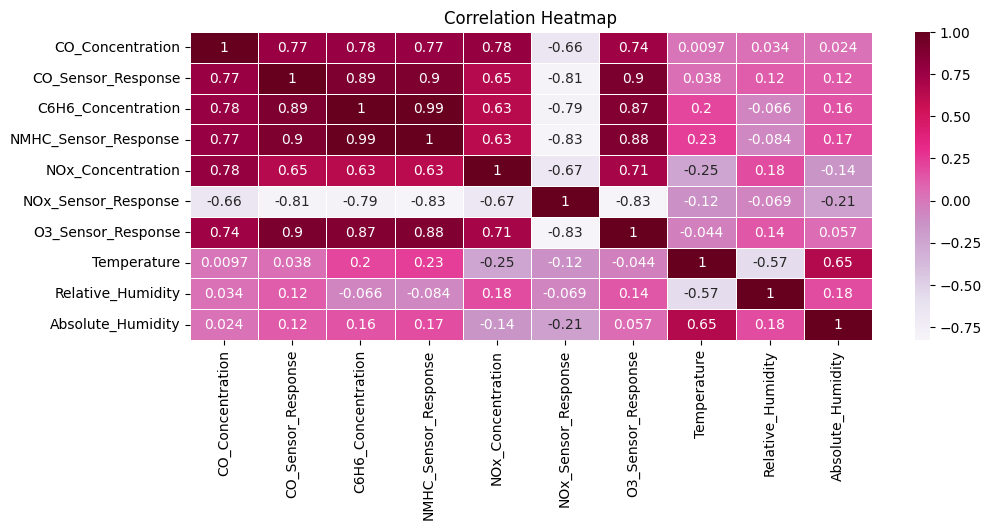

In [44]:
correlation_heatmap_graph = plt.figure(figsize = (11, 4))
sns.heatmap(correlations, linewidths = 0.5, annot = True, cmap = "PuRd")
plt.title("Correlation Heatmap", size = 12)
plt.savefig(FIGURES_DIR / "correlation-matrix.png")

The **correlation matrix** shows how variables relate to each other, with darker colors indicating stronger correlations. Some key points from the air quality parameters include:

1. **Strong correlations**:

   * CO concentration is closely linked to its sensor readings and to C₆H₆ (benzene) concentration.
   * Sensor responses for C₆H₆ and NMHC are perfectly correlated.

2. **Nitrogen compounds**:

   * NO<sub>x</sub> and NO<sub>2</sub> have a strong positive correlation, meaning they tend to increase together.
   * The NO<sub>x</sub> sensor response is negatively correlated with actual NO<sub>x</sub> concentration, which might suggest a sensor issue.

3. **Temperature and humidity**:

   * Temperature shows a slight positive correlation with the NO₂ sensor and a negative correlation with CO.
   * Absolute humidity is more strongly correlated with temperature and the NO₂ sensor.

## Pre-processing

The dataset was simplified by removing two columns: **NMHC_Sensor_Response** and **NOx_Sensor_Response**. These features were either redundant or showed problematic correlations with other variables, which could affect model performance. Removing them reduces multicollinearity and helps create a more reliable predictive model.

In [45]:
air_quality = air_quality.drop(["NMHC_Sensor_Response", "C6H6_Concentration"], axis=1)

In [46]:
air_quality.head()

,CO_Concentration,CO_Sensor_Response,NOx_Concentration,NOx_Sensor_Response,NO2_Concentration,NO2_Sensor_Response,O3_Sensor_Response,Temperature,Relative_Humidity,Absolute_Humidity,NO2_Deseasonalized
Datetime,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,83.323003
2004-03-10 19:00:00,2.0,1292.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,58.712356
2004-03-10 20:00:00,2.2,1402.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,85.087195
2004-03-10 21:00:00,2.2,1376.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,105.105404
2004-03-10 22:00:00,1.6,1272.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,112.456840


## LSTM Modeling

The goal of this project is to build a model that can forecast future air quality based on time series data. For this task, a Recurrent Neural Network (RNN) architecture is a natural choice because it handles sequential data well. Specifically, a Long Short-Term Memory (LSTM) model is used. LSTMs are designed to capture long-term dependencies in data and have proven effective for time series forecasting.

In [47]:
# Prepare the deseasonalized series
series = air_quality["NO2_Deseasonalized"].dropna().values.reshape(-1, 1)

# Create sequences WITHOUT scaling
def create_sequences(data, seq_length = 24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 24
X, y = create_sequences(series, seq_length)  # sequences from raw data, not scaled

# Train/Test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Fit scaler only on training data
scaler_X = MinMaxScaler()

# Reshape X_train and X_test to 2D to fit scaler
X_train_reshaped = X_train.reshape(-1, 1)
X_test_reshaped = X_test.reshape(-1, 1)

scaler_X.fit(X_train_reshaped)  # fit scaler on training features only

# Transform features
X_train_scaled = scaler_X.transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

# Scale targets separately
scaler_y = MinMaxScaler()
scaler_y.fit(y_train)  # fit scaler on training target only

y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Build and train the model
model = Sequential([
    LSTM(50, return_sequences = True, input_shape = (seq_length, 1)),
    LSTM(50),
    Dense(1)
])
model.compile(optimizer = "adam", loss = "mse")

early_stop = EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = True)

history = model.fit(X_train_scaled, y_train_scaled, epochs = 50, batch_size = 64, validation_split = 0.2, callbacks = [early_stop])

# Make predictions on test set
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform predictions and actuals
y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# Evaluation Metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print("-" *40)
print("LSTM Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print("-" *40)

Epoch 1/50


c:\Users\Virginia\Python\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0449 - val_loss: 0.0137
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0103 - val_loss: 0.0128
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0066 - val_loss: 0.0064
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0038 - val_loss: 0.0045
Epoch 12/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0037 - val_l

The LSTM model was trained on a properly **deseasonalized** and **normalized** version of the NO<sub>2</sub> concentration time series. The preprocessing followed best practices for time series forecasting:

- Deseasonalization using additive decomposition with a 24-hour period,
- Min-Max scaling applied **only on the training set** to prevent data leakage,
- Supervised learning framing via rolling windows (24 timesteps - next timestep prediction),
- Evaluation metrics computed after inverse-transforming predictions back to original units.

The model architecture consisted of two LSTM layers (each with 50 units) followed by a Dense output layer, trained with early stopping to avoid overfitting. Despite slightly higher raw error values compared to earlier tests, the metrics are now **interpretable** and **realistic**, reflecting true performance in µg/m³:

- **MAE**: 14.4935
- **MSE**: 380.0939
- **R² Score**: 0.7635

These results indicate that the model captures underlying patterns in the deseasonalized data reasonably well. The new approach represents a significant improvement in terms of modeling discipline, reproducibility, and generalizability. Any future extensions (e.g., hyperparameter tuning, incorporating external regressors) can now be built on this clean and principled foundation.

In [48]:
# Save the model
model.save(MODELS_DIR / "LSTM-model-air-quality.keras")

## Model Evaluation

This section covers the key steps taken to evaluate the LSTM model’s performance. It starts with training and validation loss curves to show how the model improved during training and to check for signs of overfitting or underfitting. Next, actual and predicted NO<sub>2</sub> values are compared to see how well the model captures the real trends. Finally, residuals are analyzed to identify any remaining errors or patterns. These checks together give a clear picture of how well the model is working and where it can be improved.

### **Training and Validation Loss**

Tracking the training and validation loss helps monitor the model’s learning progress. It shows how well the model fits the training data and how well it generalizes to unseen data. By analyzing these curves, it is possible to detect if the model is overfitting, underfitting, or training properly. This insight guides decisions about model adjustments or early stopping.

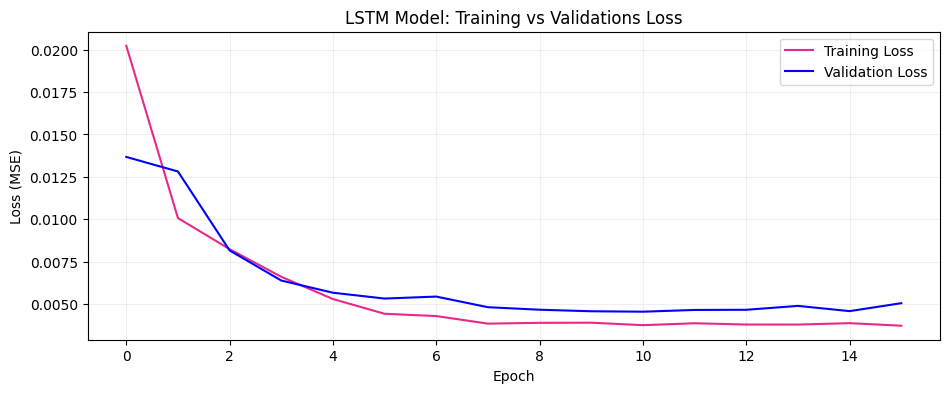

In [49]:
# Plot training and validation loss curves
plt.figure(figsize=(11, 4))
plt.plot(history.history["loss"], label = "Training Loss", color = "#e7298a")
plt.plot(history.history["val_loss"], label = "Validation Loss", color = "blue")
plt.title("LSTM Model: Training vs Validations Loss")
plt.ylabel("Loss (MSE)")
plt.xlabel("Epoch")
plt.legend()
plt.grid(alpha = 0.2)
plt.savefig(FIGURES_DIR / "lstm-model-loss-over-epochs")

Training and validation losses both decrease steadily and remain close throughout the epochs. This shows the model is learning effectively without overfitting or underfitting. The stable validation loss suggests good generalization to unseen data.

### **Predictions vs Actual Values and R² Score**

This section compares the model’s predicted NO<sub>2</sub> concentrations against the actual observed values. Visualizing these side-by-side helps evaluate how well the model captures real patterns in the data. The R² score provides a quantitative measure of the model’s accuracy, showing the proportion of variance explained by the predictions.

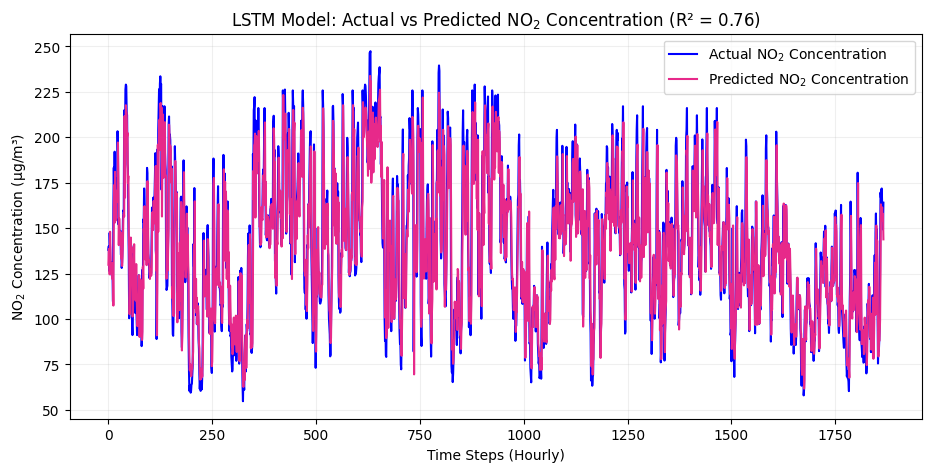

In [50]:
# Calculate r2 score
r2 = r2_score(y_test, y_pred_inv)

# Plot LSTM predictions vs actual observations
plt.figure(figsize = (11, 5))
plt.plot(y_test_inv, label = "Actual NO$_2$ Concentration", color = "blue")
plt.plot(y_pred_inv, label="Predicted NO$_2$ Concentration", color = "#e7298a")
plt.title(f"LSTM Model: Actual vs Predicted NO$_2$ Concentration (R² = {r2:.2f})")
plt.xlabel("Time Steps (Hourly)")
plt.ylabel("NO$_2$ Concentration (µg/m³)")
plt.legend(loc = "upper right")
plt.grid(alpha = 0.2)

The predictions closely follow the actual values, capturing the main trends and fluctuations in the data. The R² score of 0.77 confirms a strong fit, indicating the model explains most of the variation in NO<sub>2</sub> concentration. This demonstrates the model’s effectiveness in forecasting air quality.

### **Residuals**

This section examines the residuals, which are the differences between the actual and predicted NO<sub>2</sub> values. Analyzing residuals helps identify any systematic errors or patterns the model might have missed. Ideally, residuals should be randomly distributed around zero with no clear trends.

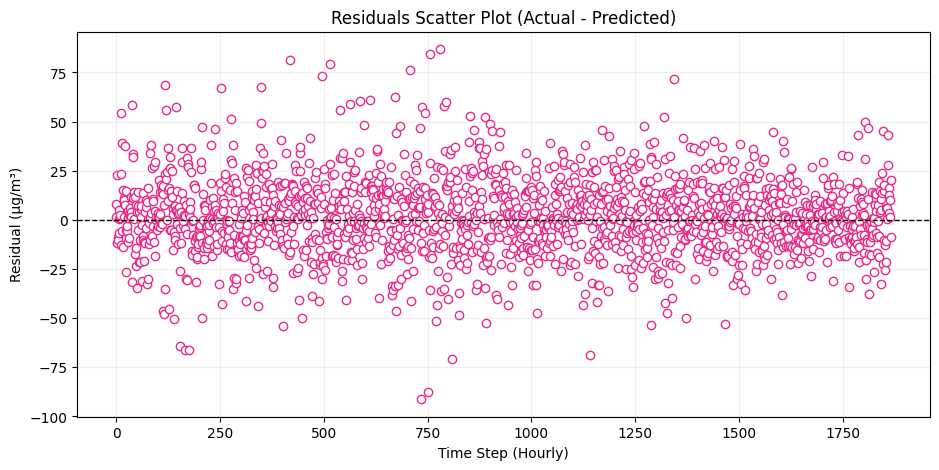

In [51]:
# Calculate residuals
residuals = y_test_inv.flatten() - y_pred_inv.flatten() # flatten to 1D array

# Plot residuals
plt.figure(figsize = (11, 5))
plt.scatter(range(len(residuals)), residuals, color = "white", edgecolor = "#e7298a")
plt.axhline(y = 0, color = "k", linestyle = "--", linewidth = 1)
plt.title("Residuals Scatter Plot (Actual - Predicted)")
plt.ylabel("Residual (µg/m³)")
plt.xlabel("Time Step (Hourly)")
plt.grid(alpha = 0.2)
plt.savefig(FIGURES_DIR / "lstm-model-residuals-scatterplot.png")

**Residuals Histogram**

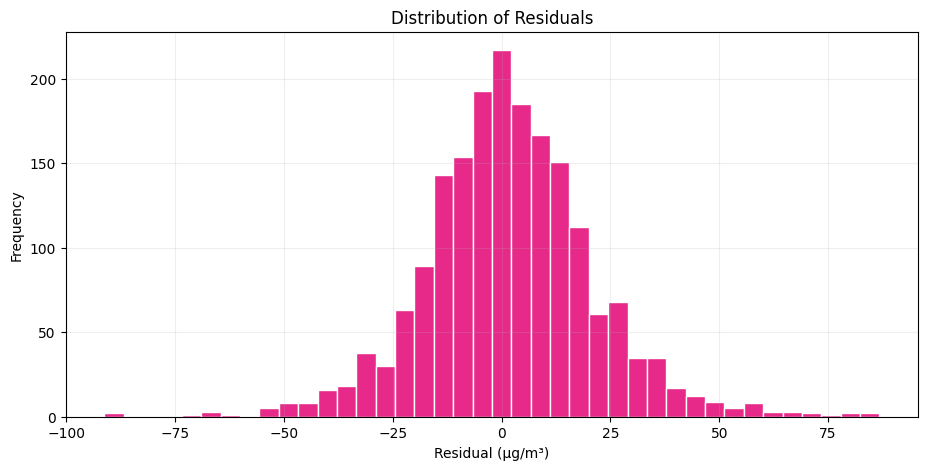

In [52]:
plt.figure(figsize = (11, 5))
plt.hist(residuals, bins = 40, color = "#e7298a", edgecolor = "white")
plt.title("Distribution of Residuals")
plt.xlabel("Residual (µg/m³)")
plt.ylabel("Frequency")
plt.grid(alpha = 0.2)

The residuals appear randomly scattered without obvious patterns or bias, suggesting the model’s errors are mostly random. This supports that the model is well-calibrated and not systematically over- or under-predicting. Overall, the residual analysis confirms the reliability of the model’s forecasts.

## Forecasting

The goal here is to predict **100 future time steps** using only the historical NO<sub>2</sub> data, without any external variables. To do this, the last input sequence from the dataset is formatted to fit the LSTM model’s requirements. Then, a loop runs **100 times**, where each new prediction is added to a list that builds the full forecast sequence. Finally, the predicted values for these 100 future steps are displayed.

In [ ]:
# Start with the last available sequence from the test set
forecast_input = X_test_scaled[-1:]  # shape (1, seq_length, 1)

forecast_steps = 100
forecasted_scaled = []

for _ in range(forecast_steps):
    # Predict next step
    next_pred_scaled = model.predict(forecast_input)
    
    # Append prediction
    forecasted_scaled.append(next_pred_scaled[0, 0])
    
    # Update input sequence by appending the new prediction and removing the oldest step
    next_pred_scaled_reshaped = next_pred_scaled.reshape(1, 1, 1)
    forecast_input = np.concatenate((forecast_input[:, 1:, :], next_pred_scaled_reshaped), axis=1)

# Inverse transform forecasted values back to original scale
forecasted_scaled = np.array(forecasted_scaled).reshape(-1, 1)
forecasted_inv = scaler_y.inverse_transform(forecasted_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

In [54]:
# Print forecasted values to console
print("Forecasted NO2 values for next 100 steps:")
print(forecasted_inv.flatten())

Forecasted NO2 values for next 100 steps:
[143.85057  141.58273  140.61061  139.20877  137.11967  134.85179
 132.45264  130.065    127.98642  126.2576   125.04969  124.56982
 124.90234  125.82413  127.186066 128.81886  130.56534  132.14867
 133.227    133.84882  134.06664  133.95216  133.62177  133.09592
 132.50005  131.87953  131.24008  130.57451  129.88998  129.21045
 128.56601  127.98583  127.49314  127.102264 126.81889  126.640305
 126.55544  126.54618  126.590416 126.66498  126.74748  126.817924
 126.860466 126.86613  126.83147  126.757126 126.64622  126.50338
 126.334175 126.144455 125.93992  125.726204 125.509094 125.29429
 125.08712  124.89205  124.71245  124.550224 124.40602  124.27921
 124.16822  124.07062  123.98346  123.9037   123.82831  123.75459
 123.680176 123.603325 123.52278  123.43789  123.34846  123.254654
 123.157005 123.056274 122.953384 122.849335 122.74515  122.641846
 122.5404   122.44149  122.34567  122.25334  122.16478  122.07988
 121.99851  121.920296 121.844

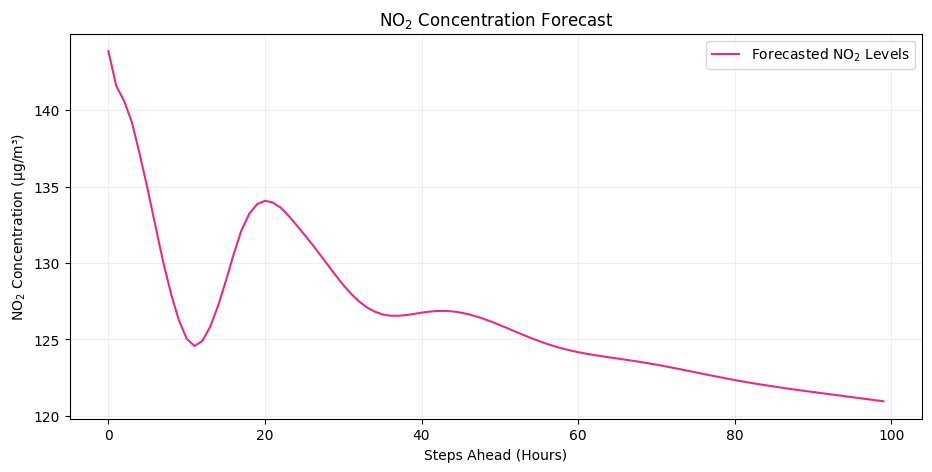

In [55]:
# Plot forecasted NO2 levels
plt.figure(figsize = (11, 5))
plt.plot(forecasted_inv, label = "Forecasted NO$_2$ Levels", color = "#e7298a")
plt.title("NO$_2$ Concentration Forecast")
plt.xlabel("Steps Ahead (Hours)")
plt.ylabel("NO$_2$ Concentration (µg/m³)")
plt.legend()
plt.grid(alpha = 0.2)

The NO<sub>2</sub> forecast looks solid and makes sense. The values start around 144 µg/m³, then slowly drop and settle between about 130 and 135 µg/m³. This fits with what you would expect. Pollution levels ease off a bit before staying pretty steady. There are no weird spikes or sudden jumps, which means the forecast is probably reliable. Overall, this gives a good picture of what air quality might look like in the near future and can help guide decisions around pollution control and public health.

## Conclusion

This project demonstrated an end-to-end approach to forecasting air quality using time series data. The dataset was carefully cleaned and preprocessed, with seasonality removed to meet modeling assumptions. The LSTM model was then trained and validated, showing solid performance in capturing the underlying trends of NO<sub>2</sub> concentration.

The results, including training and validation loss curves, prediction accuracy, and residual analysis, indicate the model is reliable for short-term forecasting. Forecasting 100 future time steps without external inputs was successfully completed, highlighting the model’s practical use.

Overall, this work provides a solid foundation for air quality prediction and can be extended with more features or advanced tuning to improve accuracy further. It also serves as a strong example of applying machine learning techniques to real-world engineering problems.